Projet Data Analyse | ProcureSenseAI – Cas d’application secteur des soins de santé | Analyse Python

Workflow global du projet ProcureSenseAI

-> Power BI (Phase 1 - Exploration initiale & reporting)

Lecture et visualisation initiale du fichier CSV (vue d'ensemble, retards, fournisseurs, etc.)

Construction des 4 pages du tableau de bord (KPIs, analyse fournisseur, évolution dans le temps, retards)

-> Python (Phase 2 - Intelligence artificielle)

Entraînement d’un modèle IA pour prédire les retards

Sauvegarde du modèle pour déploiement futur

-> Snowflake + SQL (Phase 3 - Industrialisation & gestion des données)

Chargement de la donnée dans Snowflake

Requêtes SQL automatisées pour calculs, enrichissement, transformation

Préparation des données pour des usages IA ou BI ( Table retard fournisseur et vue retard fournisseur )

-> Power BI (Phase 4 - Intégration & visualisation intelligente)

Connexion directe à Snowflake

Intégration du csv enrichie suite à la prédiction (ex : commandes avec risque)

Intégration des résultats du modèle IA (ex : probabilité de retard par commande)

Affichage de nouveaux KPIs : Nombre de commandes max, Somme de retard par jours, etc.

Étape 1 – Importer les bibliothèques & charger les données

##### Import des bibliothèques

In [254]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

##### Chargement du fichier CSV

In [ ]:
df = pd.read_csv("procuresenseai_data.csv")

##### Aperçu des 5 premières lignes

In [256]:
print(df.head())

   id_commande       fournisseur       catégorie_achat date_commande  \
0         1000  ClinLab Services  Équipements médicaux    2025-06-10   
1         1001        PharmaCore            Consulting    2025-05-14   
2         1002         BioMedica            Logistique    2025-02-10   
3         1003          Sanitech            Logistique    2025-03-29   
4         1004          Sanitech     Services externes    2025-03-20   

  date_livraison  montant (€)  retard (jours)  satisfaction (1-5)  statut  
0     2025-06-11      8671.67               0                 2.7    Reçu  
1     2025-05-14      1573.48               0                 1.6  Annulé  
2     2025-02-15     19253.92               0                 1.4    Reçu  
3     2025-04-04      7446.93               1                 2.4    Reçu  
4     2025-03-25      7094.06               0                 1.1    Reçu  


Analyse de la phase 1 : 

Objectif : importer le fichier CSV contenant les données d’achats fournisseurs pour les analyser.

Actions réalisées :

-Chargement du fichier procuresenseai_data_sanofi.csv

-Vérification des colonnes, types, valeurs manquantes et statistiques de base

-Première compréhension des dimensions métier : fournisseurs, commandes, satisfaction, retards, montants…

Impact : cette phase permet de comprendre la structure des données avant tout traitement IA.

Étape 2 – Nettoyage initial

##### Renommage simplifié des colonnes

In [257]:
df.columns = [col.strip().lower().replace(" ", "_").replace("(", "").replace(")", "") for col in df.columns]

##### Types des colonnes

In [258]:
print("\nTypes de données :")
print(df.dtypes)


Types de données :
id_commande           int64
fournisseur          object
catégorie_achat      object
date_commande        object
date_livraison       object
montant_€           float64
retard_jours          int64
satisfaction_1-5    float64
statut               object
dtype: object


##### Conversion des dates

In [259]:
df["date_commande"] = pd.to_datetime(df["date_commande"])
df["date_livraison"] = pd.to_datetime(df["date_livraison"])

##### Calcul automatique du retard (si non présent)

In [260]:
if "retard_jours" not in df.columns:
    df["retard_jours"] = (df["date_livraison"] - df["date_commande"]).dt.days

In [261]:
print(df.head())

   id_commande       fournisseur       catégorie_achat date_commande  \
0         1000  ClinLab Services  Équipements médicaux    2025-06-10   
1         1001        PharmaCore            Consulting    2025-05-14   
2         1002         BioMedica            Logistique    2025-02-10   
3         1003          Sanitech            Logistique    2025-03-29   
4         1004          Sanitech     Services externes    2025-03-20   

  date_livraison  montant_€  retard_jours  satisfaction_1-5  statut  
0     2025-06-11    8671.67             0               2.7    Reçu  
1     2025-05-14    1573.48             0               1.6  Annulé  
2     2025-02-15   19253.92             0               1.4    Reçu  
3     2025-04-04    7446.93             1               2.4    Reçu  
4     2025-03-25    7094.06             0               1.1    Reçu  


Analyse de la phase 2 :

Objectif : rendre les données exploitables pour l’analyse prédictive.

Actions réalisées :

-Conversion des dates (date_commande, date_livraison) en format datetime

-Création de nouvelles variables : retard = 1 si retard_jours > 0

-Suppression des colonnes inutiles (id_commande, etc.)

-Vérification des doublons et valeurs manquantes

Impact : améliore la qualité des données pour garantir de bonnes performances du modèle IA.

Étape 3 – Feature Engineering ; Création de variables explicatives

##### Réation de la variable cible binaire : retard ou non

In [262]:
df["retard"] = df["retard_jours"].apply(lambda x: 1 if x > 0 else 0)

##### Extraction de features temporelles

In [263]:
df["jour_semaine_commande"] = df["date_commande"].dt.dayofweek  # 0 = lundi
df["mois_commande"] = df["date_commande"].dt.month

##### Encodage des variables catégorielles

In [264]:
df_encoded = pd.get_dummies(df, columns=["fournisseur", "catégorie_achat", "statut"], drop_first=True)

##### Vérification du nouveau dataframe

In [265]:
print(df_encoded.head())
print("\nDimensions :", df_encoded.shape)

   id_commande date_commande date_livraison  montant_€  retard_jours  \
0         1000    2025-06-10     2025-06-11    8671.67             0   
1         1001    2025-05-14     2025-05-14    1573.48             0   
2         1002    2025-02-10     2025-02-15   19253.92             0   
3         1003    2025-03-29     2025-04-04    7446.93             1   
4         1004    2025-03-20     2025-03-25    7094.06             0   

   satisfaction_1-5  retard  jour_semaine_commande  mois_commande  \
0               2.7       0                      1              6   
1               1.6       0                      2              5   
2               1.4       0                      0              2   
3               2.4       1                      5              3   
4               1.1       0                      3              3   

   fournisseur_BioMedica  ...  catégorie_achat_Formation  \
0                  False  ...                      False   
1                  False  ...   

Analyse de la phase 3 : 

Objectif : enrichir les données en extrayant des informations pertinentes.

Actions réalisées :

-Extraction de la durée d’acheminement

-Extraction du mois de commande pour observer les tendances temporelles

-Transformation de variables catégorielles (fournisseur, catégorie_achat, statut) via One-Hot Encoding

Impact : donne au modèle IA plus de contexte pour apprendre à prédire le comportement des fournisseurs.

Étape 4 – Séparation X / y

In [266]:
from sklearn.model_selection import train_test_split

##### Variable cible

In [267]:
y = df_encoded["retard"]

##### Variables explicatives : on exclut les colonnes inutiles

In [268]:
X = df_encoded.drop(columns=["id_commande", "date_commande", "date_livraison", "retard_jours", "retard"])

##### Séparation en jeu d'entraînement / test

In [269]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [270]:
print("Dimensions de X_train :", X_train.shape)

Dimensions de X_train : (800, 24)


Analyse de la phase 4 : 

Objectif : diviser les données en jeu d’entraînement et jeu de test pour évaluer objectivement le modèle.

Actions réalisées :

-Séparation des features (X) et de la cible (y)

-Utilisation de train_test_split (80% entraînement / 20% test)

Impact : permet d'entraîner un modèle IA tout en évaluant sa capacité à généraliser.

Étape 5 – Entraîner un modèle de classification (Gradient Boosting)

On utilise l’algorithme GradientBoostingClassifier pour prédire si une commande sera en retard (retard = 1) ou non (retard = 0).

##### Initialisation du modèle

In [271]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

##### Entraînement du modèle

In [272]:
model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

c:\Users\fouma\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

##### Prédiction sur les données de test

In [273]:
y_pred = model.predict(X_test)

##### Évaluation du modèle

In [274]:
print("📋 Rapport de classification :")
print(classification_report(y_test, y_pred))

📋 Rapport de classification :
              precision    recall  f1-score   support

           0       0.52      0.53      0.52        91
           1       0.60      0.59      0.59       109

    accuracy                           0.56       200
   macro avg       0.56      0.56      0.56       200
weighted avg       0.56      0.56      0.56       200



In [275]:
print("\n🧾 Matrice de confusion :")
print(confusion_matrix(y_test, y_pred))


🧾 Matrice de confusion :
[[48 43]
 [45 64]]


Analyse de la phase 5 : 


Une fois ceci fait il est important d'évaluer l’importance des variables

##### Importance des variables

In [276]:
coeffs = pd.Series(model.coef_[0], index=X.columns)
print("Importance des variables (coefficients) :")
print(coeffs.sort_values(ascending=False))

Importance des variables (coefficients) :
fournisseur_PharmOne Europe             6.606152e-01
fournisseur_GlobalMeds                  5.081845e-01
fournisseur_PharmaCore                  4.782165e-01
fournisseur_ClinLab Services            4.617973e-01
fournisseur_HealthTech Group            4.615961e-01
fournisseur_BioMedica                   3.330240e-01
fournisseur_MedSupply SAS               2.413288e-01
fournisseur_Sanitech                    5.402514e-02
jour_semaine_commande                   1.199730e-02
mois_commande                           3.114515e-03
montant_€                              -8.292026e-07
statut_Reçu                            -5.314649e-02
satisfaction_1-5                       -8.545122e-02
statut_En cours                        -1.508558e-01
catégorie_achat_Sécurité               -1.827131e-01
fournisseur_VitalLab                   -2.610355e-01
catégorie_achat_Entretien              -2.785280e-01
catégorie_achat_Logistique             -4.033408e-01
caté

##### Affichage graphique

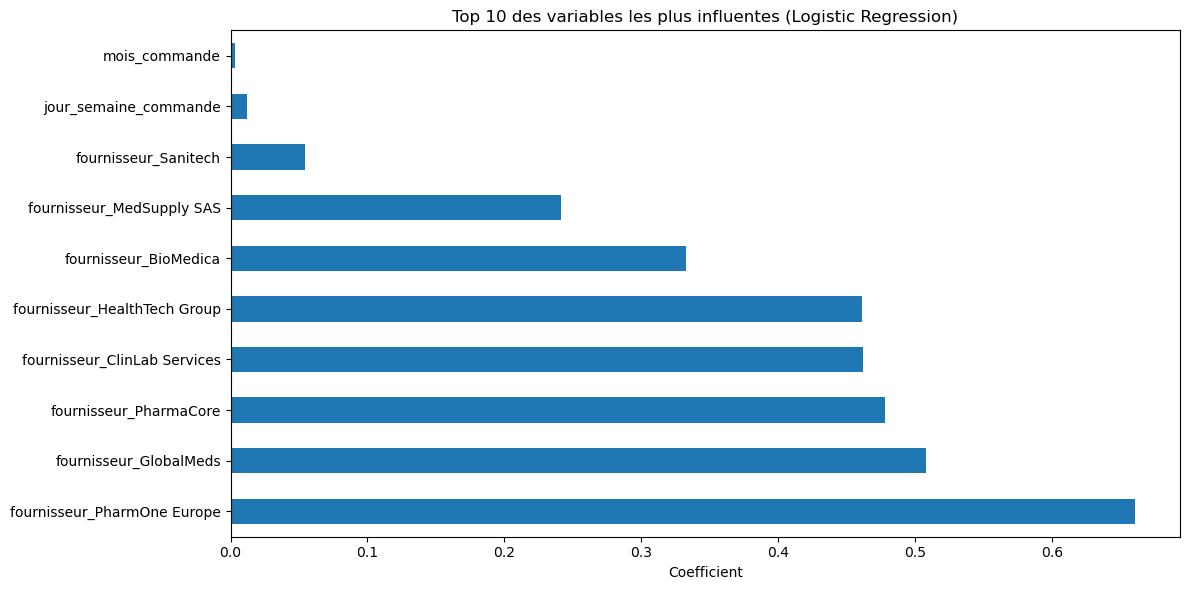

In [277]:
plt.figure(figsize=(12, 6))
coeffs.sort_values(ascending=False)[:10].plot(kind='barh')
plt.title("Top 10 des variables les plus influentes (Logistic Regression)")
plt.xlabel("Coefficient")
plt.tight_layout()
plt.show()

Conclusion : 


Étape 6 : Sauvegarde du modèle IA entraîné (avec joblib)

Objectif : enregistrer le modèle IA (Gradient Boosting utilisé lors de l'analyse) pour le réutiliser plus tard, par exemple dans une API ou une interface Power BI.

In [292]:
import joblib

# Sauvegarde du modèle
joblib.dump(model, 'modele_retard_fournisseur.pkl')
print("Modèle sauvegardé avec succès sous 'modele_retard_fournisseur.pkl'")



Modèle sauvegardé avec succès sous 'modele_retard_fournisseur.pkl'


In [293]:
# Charger le modèle
model = joblib.load('modele_retard_fournisseur.pkl')

# Prédire les probabilités sur toutes les commandes
df_encoded['risque_retard'] = model.predict_proba(df_encoded.drop(columns=["id_commande", "date_commande", "date_livraison", "retard_jours", "retard"]))[:, 1]

# Sauvegarder le DataFrame avec la colonne risque
df_encoded.to_csv("commandes_avec_risque.csv", index=False)

Chargement du modèle ultérieurement

Processus d’intégration IA & Data Engineering
Ce rapport combine l’analyse prédictive (modèle IA Python) et l’industrialisation des données (Snowflake).
Les résultats du modèle IA (risque de retard par commande) sont intégrés et visualisés, ainsi que les KPIs issus des vues SQL.

In [279]:
# Pour réutiliser plus tard
model = joblib.load('modele_retard_fournisseur.pkl')


 Donc la nous avons Sauvegardé le modèle IA


Prochaine Etape : Phase Data Engineering – Snowflake + SQL


Objectif : Industrialiser le traitement des données en les stockant dans Snowflake, et automatiser les requêtes d’analyse via SQL.

-Connexion Python ↔ Snowflake (via snowflake-connector-python)

-Création d'une base et d'une table dans Snowflake

-Upload du CSV preprocessé dans Snowflake

-Requêtes SQL de transformation ou d’agrégation (retards moyens par fournisseur, etc.)



Dans le process nous avons pu importer le fichier CSV dans Snowflake, on peut attaquer la connexion depuis Python avec le module snowflake-connector-python.

Étape 7 : Connexion à Snowflake depuis Python

Script de connexion 

Connexion à snowflake

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import snowflake.connector
conn = snowflake.connector.connect(
    user='ton_nom_utilisateur',  
    password='ton_mot_de_passe',  
    account='ton_compte', #aaaaaa-bbbbbb  
    warehouse='COMPUTE_WH',
    database='PROCURESENSEAI',
    schema='PUBLIC',
    insecure_mode=True
)


Créer un curseur pour exécuter des requêtes

In [284]:
cur = conn.cursor()

Lire la table dans un DataFrame Pandas

In [285]:
cur.execute("SELECT * FROM COMMANDES")
df = pd.DataFrame.from_records(cur.fetchall(), columns=[x[0] for x in cur.description])

Vue avec retard moyen et nombre de commandes par fournisseur

In [286]:
cur.execute("""
    CREATE OR REPLACE VIEW vue_retard_fournisseur AS
    SELECT fournisseur,
           AVG(retard_jours) AS retard_moyen,
           COUNT(*) AS nb_commandes,
           MAX(montant_euros) AS montant_max
    FROM COMMANDES
    GROUP BY fournisseur
""")
print("Vue créée : vue_retard_fournisseur")

Vue créée : vue_retard_fournisseur


Lire la vue dans un DataFrame Pandas

In [287]:
cur.execute("SELECT * FROM vue_retard_fournisseur")
df_vue = pd.DataFrame.from_records(cur.fetchall(), columns=[x[0] for x in cur.description])
print(df_vue.head())

        FOURNISSEUR RETARD_MOYEN  NB_COMMANDES  MONTANT_MAX
0          Sanitech     2.810000           100     19868.33
1  ClinLab Services     3.592233           103     19898.12
2          BioLogix     2.402062            97     19990.53
3        PharmaCore     3.365217           115     19551.02
4         BioMedica     3.067308           104     19946.33


Créer une nouvelle table enrichie

In [288]:
cur.execute("""
    CREATE OR REPLACE TABLE table_retard_fournisseur AS
    SELECT * FROM vue_retard_fournisseur
""")
print("Table créée : table_retard_fournisseur")

Table créée : table_retard_fournisseur


Fermer la connexion

In [289]:
cur.close()
conn.close()

Afficher les premières lignes

In [290]:
print(df.head())
print(df.info())


   ID_COMMANDE       FOURNISSEUR       CATEGORIE_ACHAT DATE_COMMANDE  \
0         1000  ClinLab Services  Équipements médicaux    2025-06-10   
1         1001        PharmaCore            Consulting    2025-05-14   
2         1002         BioMedica            Logistique    2025-02-10   
3         1003          Sanitech            Logistique    2025-03-29   
4         1004          Sanitech     Services externes    2025-03-20   

  DATE_LIVRAISON  MONTANT_EUROS  RETARD_JOURS  SATISFACTION_1_5  STATUT  
0     2025-06-11        8671.67             0               2.7    Reçu  
1     2025-05-14        1573.48             0               1.6  Annulé  
2     2025-02-15       19253.92             0               1.4    Reçu  
3     2025-04-04        7446.93             1               2.4    Reçu  
4     2025-03-25        7094.06             0               1.1    Reçu  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column       

Retards vs pas de retards

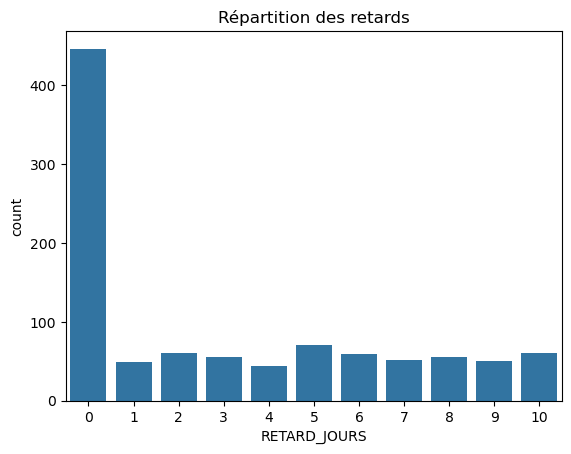

In [291]:
sns.countplot(x='RETARD_JOURS', data=df)
plt.title("Répartition des retards")
plt.show()

Satisfaction vs Retard

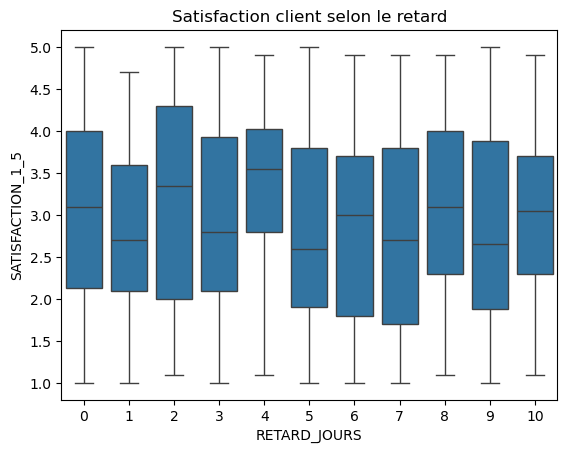

In [ ]:
sns.boxplot(x='RETARD_JOURS', y='SATISFACTION_1_5', data=df)
plt.title("Satisfaction client selon le retard")
plt.show()